In [64]:
import os
import shap
import getpass
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.optimizers import Adam
from keras.models import Sequential
from datetime import timedelta, datetime
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import models, layers, optimizers
from keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras import backend as K, losses, optimizers, layers, models, utils, callbacks


# Make sure to update the paths in this notebook
This cell below and one of the last cells in Save Preformance needs your local path to your data

## Load Data 🩻

In [56]:
# Update this path
data_dir = "/Users/owenclary/code/Owencclary/x_ray_lewagon2024/data/Bone Break Classification"

# Load the train data
train_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=40
)
[]
# Load the test data
validation_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="validation",
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=42
)

Found 9391 files belonging to 11 classes.
Using 8452 files for training.
Found 9391 files belonging to 11 classes.
Using 939 files for validation.


## Prepresses Data 🔧

In [57]:
# Inspect class names
class_names = train_data.class_names
print("Class names:", class_names)

Class names: ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture', 'non_fractured']


In [58]:
# Data preprocessing
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

train_dataset = train_data.map(lambda x, y: (preprocess(x), y))
val_dataset = validation_data.map(lambda x, y: (preprocess(x), y))

In [59]:
# Get train data and labels
x_train = []
y_train = []

for images, labels in train_dataset:
    # Append train data to x_train
    x_train.append(images.numpy())

    # Append labels to y_train
    y_train.append(labels.numpy())

# Concatenate all the batches to get the full list
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

In [60]:
# Get val data and labels
x_val = []
y_val = []

for images, labels in val_dataset:
    # Append train data to x_train
    x_val.append(images.numpy())

    # Append labels to y_train
    y_val.append(labels.numpy())

# Concatenate all the batches to get the full list
x_val = np.concatenate(x_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

In [61]:
# One-hot encode the train, val data
NUM_CLASSES = len(class_names)

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_val = utils.to_categorical(y_val, NUM_CLASSES)

In [68]:
# Further data augmentation for EfficientNet
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=True,
)

train_generator = datagen.flow(x_train, y_train, batch_size=32)
val_generator = datagen.flow(x_val, y_val, batch_size=32)

## Initialize Model 🤌



In [72]:
def initialize_model(x_train, num_classes):
    model = Sequential()

    # Add the DenseNet121 base model
    densenet = DenseNet121(include_top=False, input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), weights='imagenet')
    model.add(densenet)

    # Add global average pooling layer
    model.add(GlobalAveragePooling2D())

    # Add a fully connected layer with 1024 units and ReLU activation
    model.add(Dense(1024, activation='relu'))

    # Add the output layer with softmax activation
    model.add(Dense(num_classes, activation='softmax'))  # Adjust the number of classes as per your requirement

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

model = initialize_model(x_train, NUM_CLASSES)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_9 (Dense)             (None, 11)                11275     
                                                                 
Total params: 8,098,379
Trainable params: 8,014,731
Non-trainable params: 83,648
_________________________________________________________________


## Train the Model 💪 

In [73]:
# Save checkpoints to monitor best performing models
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/best_model_weights.h5",
    save_weights_only=True,  # Save only the weights
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

tensorboard_callback = callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch'
)

In [74]:
# Start timer
start_train_time = datetime.now()

epochs = 10

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Fit the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint_callback, tensorboard_callback]
)


# End timer
end_train_time = datetime.now()
train_time = (end_train_time - start_train_time).total_seconds()

Epoch 1/10
 43/265 [===>..........................] - ETA: 1:02:11 - loss: 2.5506 - accuracy: 0.1381

KeyboardInterrupt: 

## Evaluate the Model 🕵️‍♂️

In [ ]:
# Get Loss and Accuracy metrics
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["accuracy"]

print('Train Loss: ', train_loss)
print('Train Accuracy: ', train_accuracy)
print('Val Loss: ', val_loss)
print('Val Accuracy: ', val_accuracy)

Train Loss:  [2.2816195487976074]
Train Accuracy:  [0.20469921827316284]
Val Loss:  [1.8664095401763916]
Val Accuracy:  [0.20469921827316284]


In [ ]:
# Start timer
start_eval_time = datetime.now()

# Evaluate model
model.evaluate(x_val, y_val)

# End timer
end_eval_time = datetime.now()
eval_time = (end_eval_time - start_eval_time).total_seconds()

29/29 [==============================] - 2s 80ms/step - loss: 1.8664 - accuracy: 0.3322


## Plote Learning Curve 📊

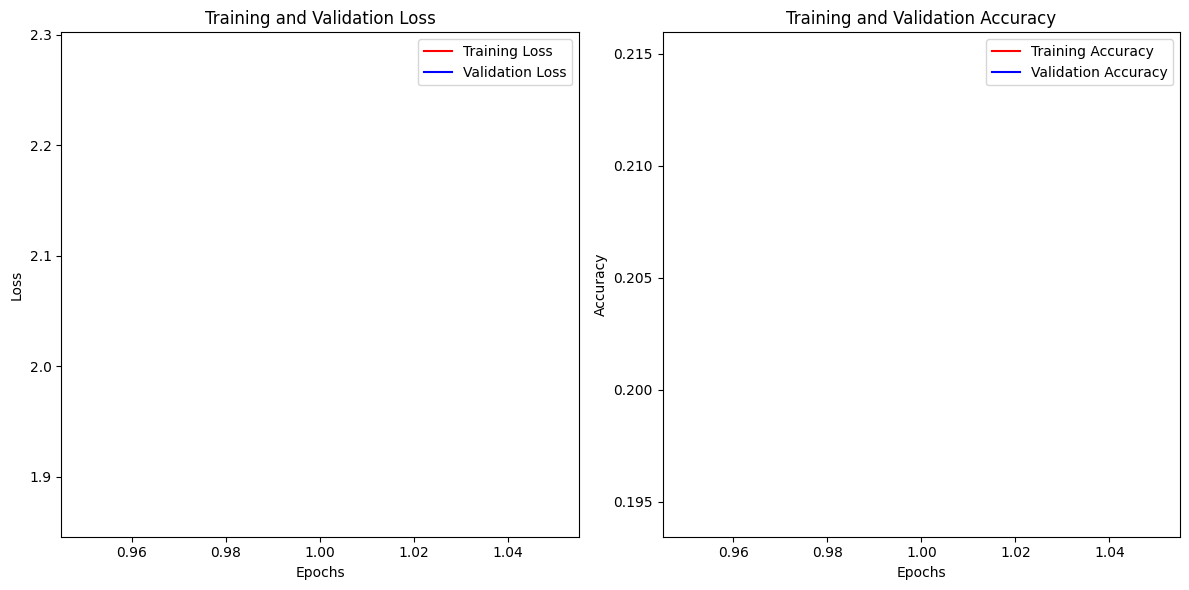

In [ ]:
# Plot learning curve
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r-', label="Training Loss")
plt.plot(epochs, val_loss, 'b-', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r-', label="Training Accuracy")
plt.plot(epochs, val_accuracy, 'b-', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Calculate Preformance 🔍

In [ ]:
# Start prediction timer
start_pred_time = datetime.now()

# Get predictions of the model
preds = model.predict(x_val)
CLASSES = np.array(class_names)
predictions = CLASSES[np.argmax(preds, axis=-1)]
y_val_classes = CLASSES[np.argmax(y_val, axis=-1)]

# Ender prediction timer
end_pred_time = datetime.now()
pred_time = (end_pred_time - start_pred_time).total_seconds()

29/29 [==============================] - 3s 83ms/step


In [ ]:
# Calculate accuracy, precision, recall, f1
accuracy = accuracy_score(predictions, y_val_classes)
precision = precision_score(predictions, y_val_classes, average='weighted')
recall = recall_score(predictions, y_val_classes, average='weighted')
f1 = f1_score(predictions, y_val_classes, average='weighted')

# Save the metrics to a file
with open("metrics.txt", "w") as file:
    file.write(f"{accuracy}\n")
    file.write(f"{precision}\n")
    file.write(f"{recall}\n")
    file.write(f"{f1}\n")

# Optionally, print the metrics for quick reference
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.33222591362126247
Precision: 0.3973485470458879
Recall: 0.33222591362126247
F1 Score: 0.33687774640556367


## Save Preformance to CSV 📝

In [ ]:
def log_model_metrics(metrics_file, csv_file, model_name, train_time, eval_time, pred_one_time):

    # Load metrics generated by train_eval.py
    metrics_df = pd.read_csv(metrics_file, header=None, names=["value"])
    accuracy = float(metrics_df.iloc[0].value)
    precision = float(metrics_df.iloc[1].value)
    recall = float(metrics_df.iloc[2].value)
    f1 = float(metrics_df.iloc[3].value)

    # Log results to DataFrame
    columns = ["name", "model", "train_time", "test_time", "pred_one_time", "accuracy", "precision", "recall", "f1"]
    name = getpass.getuser()  # Get the username of the person running the script

    # Create a DataFrame to hold the new data
    data = {
        "name": [name],
        "model": [model_name],
        "train_time": [train_time],
        "eval_time": [eval_time],
        "pred_one_time": [pred_one_time],
        "accuracy": [accuracy],
        "precision": [precision],
        "recall": [recall],
        "f1": [f1]
    }
    df_new = pd.DataFrame(data)

    # Check if the file exists
    if os.path.exists(csv_file):
        # If the file exists, append the new data
        df_existing = pd.read_csv(csv_file)
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        # If the file does not exist, the new data is the combined data
        df_combined = df_new

    # Save the combined data to the CSV file
    df_combined.to_csv(csv_file, index=False)


In [ ]:
def preprocess_single_image(img_path, target_size=(256, 256)):
    """
    Load and preprocess a single image
    """
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize if needed
    return img_array

In [ ]:
def predict_single_image(model, img_array, class_names_dict):
    """
    Make a prediction on a single image
    """
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds, axis=-1)
    class_name = class_names_dict[predicted_class[0]]
    return class_name


In [ ]:
# Update this path to any single image
img_path = "/Users/owenclary/code/Owencclary/x_ray_lewagon2024/data/Bone Break Classification/Avulsion fracture/Train/94f6a-pclavulsion1a_png.rf.621b9fb0ecda5666f169e06b88d35b9e.jpg"

# Preprocess a single image
img_array = preprocess_single_image(img_path)

class_names_dict = {
    0: 'Avulsion fracture',
    1: 'Comminuted fracture',
    2: 'Fracture Dislocation',
    3: 'Greenstick fracture',
    4: 'Hairline Fracture',
    5: 'Impacted fracture',
    6: 'Longitudinal fracture',
    7: 'Oblique fracture',
    8: 'Pathological fracture',
    9: 'Spiral Fracture'
}

Predict One Image

In [ ]:
# Start single image prediction timer
start_pred_one_time = datetime.now()

# Predict one image
predicted_class_name = predict_single_image(model, img_array, class_names_dict)
print("Predicted class:", predicted_class_name)

# End timer
end_pred_one_time = datetime.now()
pred_one_time = (end_pred_one_time - start_pred_one_time).total_seconds()

1/1 [==============================] - 0s 15ms/step
Predicted class: Hairline Fracture


In [ ]:
# Run log model metrics function
log_model_metrics("metrics.txt", "results.csv", "Original-CNN-Kaggle", train_time, eval_time, pred_one_time)

## Examine Data 📊

In [ ]:
# Read the results csv
res = pd.read_csv('/Users/owenclary/code/Owencclary/x_ray_lewagon2024/notebooks/results.csv')

res

,name,model,train_time,eval_time,pred_one_time,accuracy,precision,recall,f1
0,owenclary,Original-CNN-Kaggle,6960.186786,2.395517,0.045547,0.956811,0.957546,0.956811,0.956908
1,owenclary,Original-CNN-Kaggle,112.976097,3.232416,0.064276,0.956811,0.957546,0.956811,0.956908
2,owenclary,Original-CNN-Kaggle,91.785977,2.873308,0.044210,0.292359,0.470460,0.292359,0.337289
3,owenclary,Original-CNN-Kaggle,102.529801,2.633100,0.140494,0.292359,0.470460,0.292359,0.337289
4,owenclary,Original-CNN-Kaggle,102.529801,2.633100,0.166743,0.292359,0.470460,0.292359,0.337289
5,owenclary,Original-CNN-Kaggle,102.529801,2.633100,0.135491,0.292359,0.470460,0.292359,0.337289
6,owenclary,Original-CNN-Kaggle,102.529801,2.633100,0.063447,0.292359,0.470460,0.292359,0.337289
7,owenclary,Original-CNN-Kaggle,102.529801,2.633100,0.212898,0.292359,0.470460,0.292359,0.337289
8,owenclary,Original-CNN-Kaggle,102.529801,2.633100,0.161556,0.292359,0.470460,0.292359,0.337289
9,owenclary,Original-CNN-Kaggle,102.529801,2.633100,0.049048,0.292359,0.470460,0.292359,0.337289


## Shapley  🚀


  0%|          | 0/7998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.48s/it]               


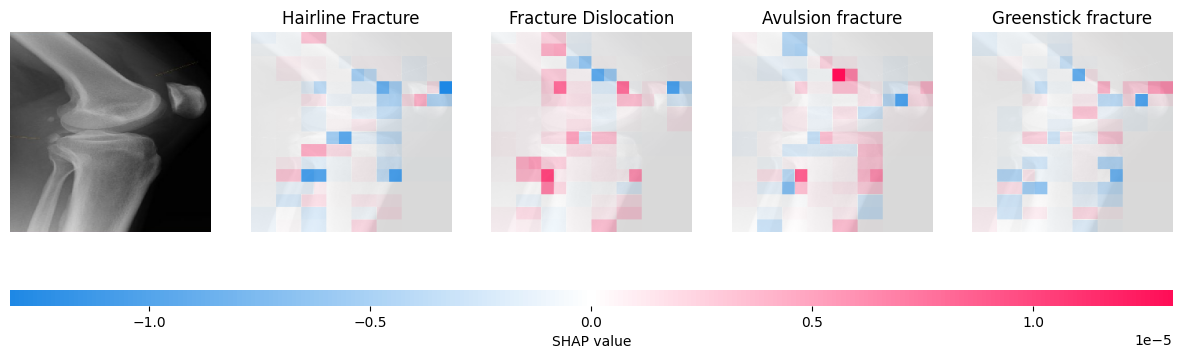

In [ ]:
# Masker that will mask out partitions of the input image with smaller blur
masker = shap.maskers.Image("blur(16, 16)", img_array[0].shape)

# Create the explainer
explainer = shap.Explainer(model, masker, output_names=list(class_names_dict.values()))

# Explain the single image to estimate SHAP values
shap_values = explainer(img_array, max_evals=8000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])  # Increased max_evals

# Show the plot
shap.image_plot(shap_values, pixel_values=img_array)